# Entrenamiento y Evaluación de Modelos

### Configuración experimental

Metodología de validación
   - Validación cruzada estratificada (StratifiedKFold con 5 folds) sobre el conjunto de entrenamiento (70%) para ajustar hiperparámetros.
   - Test final (30%) separado y usado únicamente al concluir CrossValidation.

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print(" Librerías cargadas")


 Librerías cargadas


## Plan de modelos e hiperparámetros

| Modelo | Tipo | Hiperparámetro | Valores | Descripción |
|---|---|---|---|---|
| Regresión logística ordinal (aproximada con `LogisticRegression`) | Paramétrico | `C` | [0.01, 0.1, 1, 10] | Controla la regularización L2 |
|  |  | `solver` | ['lbfgs'] | Algoritmo estable para multiclass |
| k-NN | No paramétrico | `n_neighbors` | [3,5,7,9,11] | Número de vecinos |
|  |  | `weights` | ['uniform','distance'] | Cómo ponderar vecinos |
| Random Forest | Ensamble | `n_estimators` | [100,200,500] | Cantidad de árboles |
|  |  | `max_depth` | [None,10,20] | Profundidad máxima |
| Gradient Boosting | Ensamble | `learning_rate` | [0.01,0.05,0.1] | Tasa de aprendizaje |
|  |  | `n_estimators` | [100,200,300] | Cantidad de iteraciones |
| MLP | Red neuronal | `hidden_layer_sizes` | [(50,),(100,),(50,50)] | Arquitectura |
|  |  | `alpha` | [0.0001,0.001,0.01] | Regularización L2 |
| SVM | Línea de soporte | `C` | [0.1,1,10] | Regularización |
|  |  | `kernel` | ['linear','rbf'] | Tipo de kernel |

> Las mallas se prueban combinando todos los valores por modelo mediante `GridSearchCV` con `StratifiedKFold`. `class_weight='balanced'` se habilita para compensar posibles asimetrías en las clases.


## Métricas de desempeño

1. **MAE ordinal** (distancia absoluta promedio en la escala ordinal). Métrica principal porque penaliza errores proporcionalmente a la posición ordinal.
2. **Accuracy**: proporción de predicciones correctas. Sirve como referencia tradicional.
3. **Spearman**: correlación de rangos, refleja el orden en las predicciones.
4. **Confusión**: matriz para inspeccionar qué clases se confunden.

In [90]:
# Cargar datos preprocesados
data_train = pd.read_csv('data/processed/X_train.csv')
data_val = pd.read_csv('data/processed/X_test.csv')
y_train = pd.read_csv('data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('data/processed/y_test.csv').squeeze()

data_train.shape, data_val.shape, y_train.shape


((1477, 25), (634, 25), (1477,))

In [91]:
def safe_spearman(y_true, y_pred):
    corr = spearmanr(y_true, y_pred).correlation
    return 0 if np.isnan(corr) else corr

print("Funciones auxiliares listas")


Funciones auxiliares listas


In [92]:
def spearman_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return pd.Series(preds).corr(pd.Series(y), method='spearman')

mae_scorer = make_scorer(lambda y_true, y_pred: np.mean(np.abs(y_true - y_pred)), greater_is_better=False)

print("Funciones de scoring listas")



Funciones de scoring listas


### Entrenamiento y evaluación

In [93]:
from collections import defaultdict
from scipy.stats import spearmanr

models = {
    'LogisticRegression': {
        'est': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced'),
        'grid': {
            'clf__C': [0.01, 0.1, 1, 10]
        }
    },
    'kNN': {
        'est': KNeighborsClassifier(),
        'grid': {
            'clf__n_neighbors': [3, 5, 7],
            'clf__weights': ['uniform', 'distance']
        }
    },
    'RandomForest': {
        'est': RandomForestClassifier(class_weight='balanced', n_jobs=-1),
        'grid': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10],
            'clf__min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'est': GradientBoostingClassifier(),
        'grid': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5]
        }
    },
    'MLP': {
        'est': MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
        'grid': {
            'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'clf__alpha': [0.0001, 0.001],
            'clf__learning_rate': ['adaptive']
        }
    },
    'SVM': {
        'est': SVC(class_weight='balanced', probability=False),
        'grid': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale']
        }
    }
}

scoring = {
    'mae': mae_scorer,
    'accuracy': 'accuracy',
    'spearman': make_scorer(safe_spearman)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_models = {}

for name, spec in models.items():
    pipe = Pipeline([('scale', StandardScaler()), ('clf', spec['est'])])
    grid = GridSearchCV(pipe, spec['grid'], scoring=scoring, refit='mae', cv=cv, n_jobs=1, return_train_score=False)
    grid.fit(data_train, y_train)
    best = grid.best_estimator_
    best_models[name] = best
    best_index = grid.best_index_
    cv_mae_scores = -np.array([grid.cv_results_[f'split{i}_test_mae'][best_index] for i in range(cv.get_n_splits())])
    cv_accuracy = np.array([grid.cv_results_[f'split{i}_test_accuracy'][best_index] for i in range(cv.get_n_splits())])
    cv_spearman = np.array([grid.cv_results_[f'split{i}_test_spearman'][best_index] for i in range(cv.get_n_splits())])

    train_preds = best.predict(data_train)
    test_preds = best.predict(data_val)

    results.append({
        'modelo': name,
        'params': grid.best_params_,
        'cv_mae_mean': cv_mae_scores.mean(),
        'cv_mae_ci': (np.percentile(cv_mae_scores, 2.5), np.percentile(cv_mae_scores, 97.5)),
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_ci': (np.percentile(cv_accuracy, 2.5), np.percentile(cv_accuracy, 97.5)),
        'cv_spearman_mean': cv_spearman.mean(),
        'cv_spearman_ci': (np.percentile(cv_spearman, 2.5), np.percentile(cv_spearman, 97.5)),
        'train_mae': mean_absolute_error(y_train, train_preds),
        'train_acc': accuracy_score(y_train, train_preds),
        'test_mae': mean_absolute_error(y_test, test_preds),
        'test_acc': accuracy_score(y_test, test_preds)
    })
    print(f" {name} terminado")

results_df = pd.DataFrame(results)
results_df


 LogisticRegression terminado
 kNN terminado
 RandomForest terminado
 GradientBoosting terminado
 MLP terminado
 SVM terminado


,modelo,params,cv_mae_mean,cv_mae_ci,cv_accuracy_mean,cv_accuracy_ci,cv_spearman_mean,cv_spearman_ci,train_mae,train_acc,test_mae,test_acc
0,LogisticRegression,{'clf__C': 10},0.130685,"(0.08449839670178654, 0.18062414109024277)",0.935676,"(0.919569399908383, 0.9580897846999542)",0.947652,"(0.9211550751077741, 0.9677658214039215)",0.055518,0.968856,0.222397,0.924290
1,kNN,"{'clf__n_neighbors': 5, 'clf__weights': 'dista...",0.504455,"(0.37003206596426935, 0.7143987631699495)",0.813795,"(0.7698969308291342, 0.8469044892349977)",0.754829,"(0.6318898777123549, 0.8346046132288983)",0.000000,1.000000,0.599369,0.780757
2,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.046706,"(0.034576271186440674, 0.06285501603298213)",0.981044,"(0.9766823179111315, 0.98310238204306)",0.977695,"(0.96369722538729, 0.9887064720144725)",0.000000,1.000000,0.108833,0.966877
3,GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.045350,"(0.031186440677966103, 0.06285501603298213)",0.973598,"(0.9665437471369674, 0.9823808978469996)",0.983558,"(0.9757859357085781, 0.9893559749689557)",0.000000,1.000000,0.047319,0.976341
4,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.293820,"(0.268135593220339, 0.3144720568025653)",0.881530,"(0.8634734310581769, 0.8997010994044893)",0.863527,"(0.8510366224459572, 0.8753985967811165)",0.037915,0.981043,0.422713,0.862776
5,SVM,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...",0.066333,"(0.030508474576271188, 0.08437929454878607)",0.962765,"(0.9501694915254237, 0.9810295464956482)",0.976144,"(0.967921471596339, 0.9901895354654122)",0.031144,0.981043,0.135647,0.949527


### Resultados resumidos

La tabla anterior agrupa los mejores hiperparámetros y las métricas MAE, accuracy y Spearman


### Visualizaciones de desempeño

In [94]:
import os
os.makedirs('results/figuras', exist_ok=True)
print('Directorio results/figuras asegurado')


Directorio results/figuras asegurado


Figura guardada: results/figuras/learning_curves.png


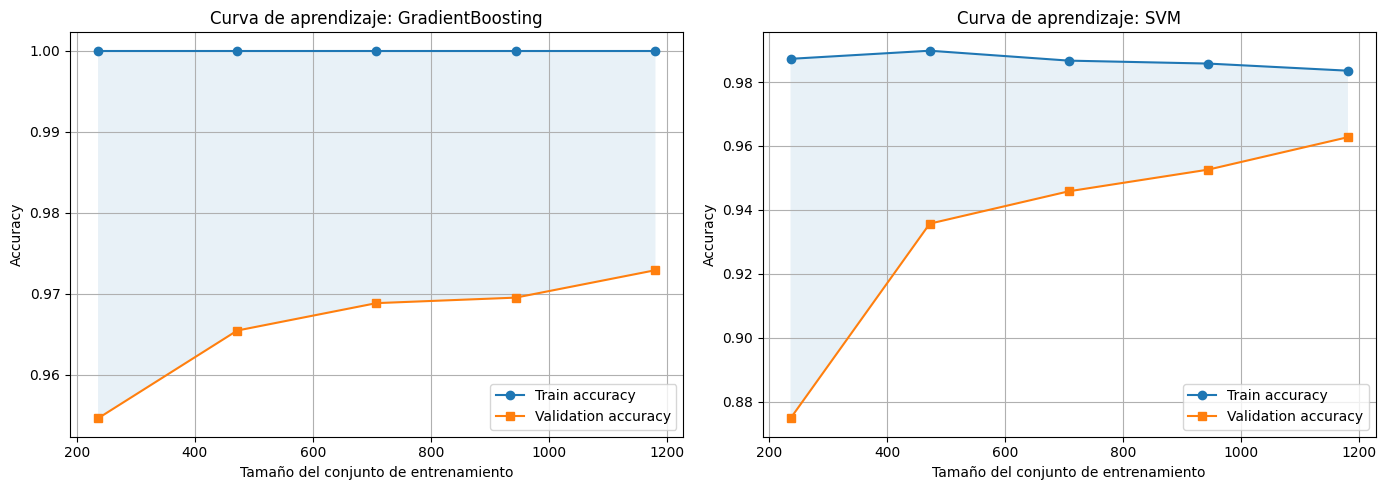

In [95]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay

with open('models/preprocessing/target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)
labels = target_encoder.classes_

best_two = ['GradientBoosting', 'SVM']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, name in zip(axes, best_two):
    estimator = best_models[name]
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, data_train, y_train, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=1, shuffle=True, random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    ax.plot(train_sizes, train_mean, label='Train accuracy', marker='o')
    ax.plot(train_sizes, test_mean, label='Validation accuracy', marker='s')
    ax.fill_between(train_sizes, train_mean, test_mean, alpha=0.1)
    ax.set_title(f'Curva de aprendizaje: {name}')
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('results/figuras/learning_curves.png', dpi=200)
print('Figura guardada: results/figuras/learning_curves.png')



Figura guardada: results/figuras/cv_mae_comparison.png


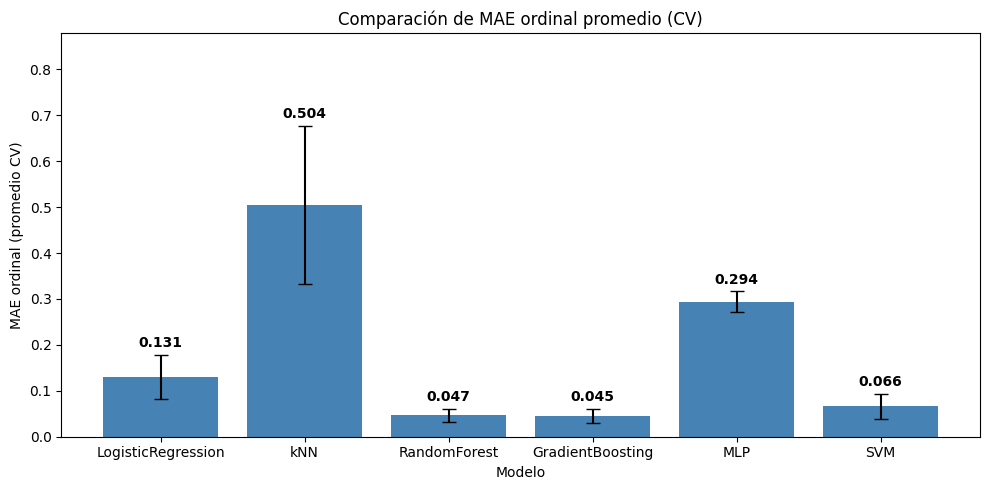

In [96]:
fig, ax = plt.subplots(figsize=(10, 5))
labels = results_df['modelo']
means = results_df['cv_mae_mean']
cis = results_df['cv_mae_ci'].tolist()
errors = [(ci[1] - ci[0]) / 2 for ci in cis]
ax.bar(labels, means, yerr=errors, capsize=5, color='steelblue')
ax.set_title('Comparación de MAE ordinal promedio (CV)')
ax.set_ylabel('MAE ordinal (promedio CV)')
ax.set_xlabel('Modelo')
ax.set_ylim(0, max(means + errors) * 1.3)
for i, (m, err) in enumerate(zip(means, errors)):
    ax.text(i, m + err + 0.01, f"{m:.3f}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.savefig('results/figuras/cv_mae_comparison.png', dpi=200)
print('Figura guardada: results/figuras/cv_mae_comparison.png')


Figura guardada: results/figuras/confusion_matrices.png


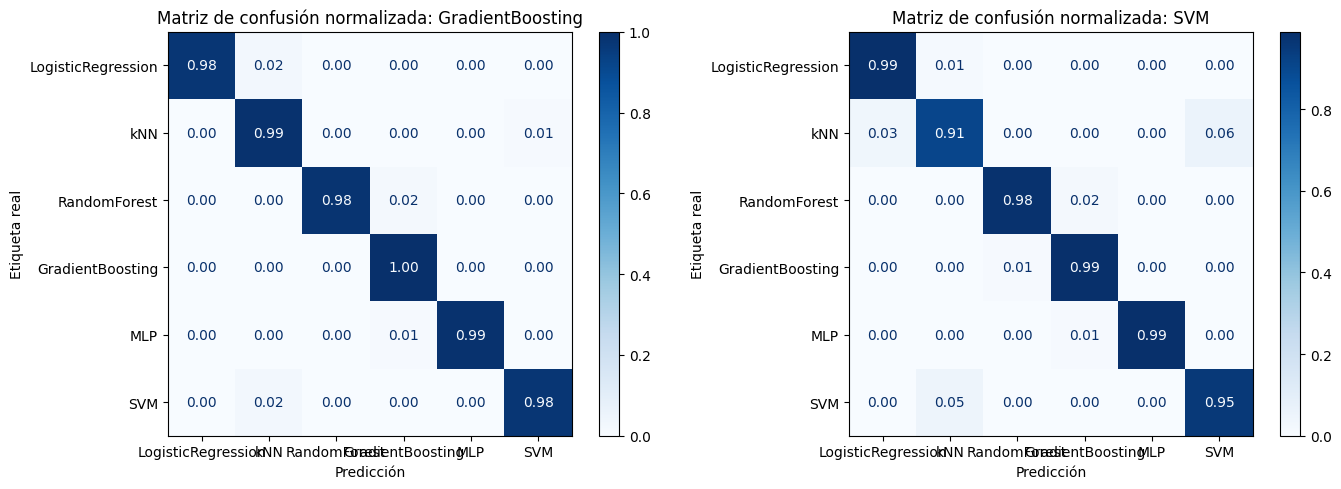

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, name in zip(axes, best_two):
    preds = best_models[name].predict(data_val)
    cm = confusion_matrix(y_test, preds, labels=np.arange(len(labels)))
    cm_norm = cm.astype('float')
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=True, include_values=True, values_format='.2f')
    ax.set_title(f'Matriz de confusión normalizada: {name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Etiqueta real')
plt.tight_layout()
plt.savefig('results/figuras/confusion_matrices.png', dpi=200)
print('Figura guardada: results/figuras/confusion_matrices.png')


In [98]:
results_df_display = results_df[['modelo', 'params', 'cv_mae_mean', 'cv_mae_ci', 'cv_accuracy_mean', 'cv_accuracy_ci', 'cv_spearman_mean', 'cv_spearman_ci', 'test_mae', 'test_acc']]
results_df_display


,modelo,params,cv_mae_mean,cv_mae_ci,cv_accuracy_mean,cv_accuracy_ci,cv_spearman_mean,cv_spearman_ci,test_mae,test_acc
0,LogisticRegression,{'clf__C': 10},0.130685,"(0.08449839670178654, 0.18062414109024277)",0.935676,"(0.919569399908383, 0.9580897846999542)",0.947652,"(0.9211550751077741, 0.9677658214039215)",0.222397,0.924290
1,kNN,"{'clf__n_neighbors': 5, 'clf__weights': 'dista...",0.504455,"(0.37003206596426935, 0.7143987631699495)",0.813795,"(0.7698969308291342, 0.8469044892349977)",0.754829,"(0.6318898777123549, 0.8346046132288983)",0.599369,0.780757
2,RandomForest,"{'clf__max_depth': None, 'clf__min_samples_lea...",0.046706,"(0.034576271186440674, 0.06285501603298213)",0.981044,"(0.9766823179111315, 0.98310238204306)",0.977695,"(0.96369722538729, 0.9887064720144725)",0.108833,0.966877
3,GradientBoosting,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.045350,"(0.031186440677966103, 0.06285501603298213)",0.973598,"(0.9665437471369674, 0.9823808978469996)",0.983558,"(0.9757859357085781, 0.9893559749689557)",0.047319,0.976341
4,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.293820,"(0.268135593220339, 0.3144720568025653)",0.881530,"(0.8634734310581769, 0.8997010994044893)",0.863527,"(0.8510366224459572, 0.8753985967811165)",0.422713,0.862776
5,SVM,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...",0.066333,"(0.030508474576271188, 0.08437929454878607)",0.962765,"(0.9501694915254237, 0.9810295464956482)",0.976144,"(0.967921471596339, 0.9901895354654122)",0.135647,0.949527


### Importancia de variables por modelo

In [99]:
from sklearn.inspection import permutation_importance

feature_names = data_train.columns.tolist()
importance_by_model = {}

for name, estimator in best_models.items():
    result = permutation_importance(
        estimator,
        data_val,
        y_test,
        n_repeats=10,
        scoring='accuracy',
        random_state=42,
        n_jobs=1
    )
    importance_by_model[name] = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

importance_summary = pd.concat([
    imp.to_frame("importance")
       .reset_index()
       .rename(columns={"index": "feature"})
       .assign(model=name)
    for name, imp in importance_by_model.items()
], ignore_index=True)[["model", "feature", "importance"]]

print('Top 5 variables por modelo (permutation importance sobre test):')
for name, importance in importance_by_model.items():
    print(f'\n{name}:')
    print(importance.to_string())

importance_summary


Top 5 variables por modelo (permutation importance sobre test):

LogisticRegression:
BMI                               0.664669
Gender                            0.176814
FCVC                              0.078076
Age                               0.060726
FAVC                              0.022555
family_history_with_overweight    0.020505
NCP                               0.019401
CALC_Sometimes                    0.006782
FAF                               0.005521
CALC_Frequently                   0.005205
CAEC_Always                       0.004732
TUE                               0.004574
MTRANS_Walking                    0.004416
CH2O                              0.004101
SCC                               0.003470
MTRANS_Automobile                 0.001735
CAEC_no                           0.001420
CALC_no                           0.001420
MTRANS_Public_Transportation      0.001262
MTRANS_Motorbike                  0.001104
MTRANS_Bike                       0.000631
CALC_Always 

,model,feature,importance
0,LogisticRegression,BMI,0.664669
1,LogisticRegression,Gender,0.176814
2,LogisticRegression,FCVC,0.078076
3,LogisticRegression,Age,0.060726
4,LogisticRegression,FAVC,0.022555
...,...,...,...
145,SVM,MTRANS_Motorbike,0.000000
146,SVM,CALC_Always,0.000000
147,SVM,MTRANS_Walking,-0.000158
148,SVM,MTRANS_Bike,-0.001577


### Importancia agrupada de variables categóricas

In [100]:
category_groups = {
    'CAEC': 'CAEC_',
    'CALC': 'CALC_',
    'MTRANS': 'MTRANS_'
}

def aggregate_importances(importance_dict):
    grouped_dict = {}
    for name, imp in importance_dict.items():
        consumed = set()
        rows = []
        for group_name, prefix in category_groups.items():
            group_feats = [feat for feat in imp.index if feat.startswith(prefix)]
            if not group_feats:
                continue
            total = imp.loc[group_feats].abs().sum()
            rows.append((group_name, total))
            consumed.update(group_feats)
        for feat in imp.index:
            if feat not in consumed:
                rows.append((feat, abs(imp.loc[feat])))
        grouped_series = pd.Series(
            [value for _, value in rows],
            index=[label for label, _ in rows]
        ).sort_values(ascending=False)
        grouped_dict[name] = grouped_series
    return grouped_dict

aggregated_importance = aggregate_importances(importance_by_model)

aggregated_summary = pd.concat([
    imp.to_frame('importance')
       .reset_index()
       .rename(columns={'index': 'feature'})
       .assign(model=name)
    for name, imp in aggregated_importance.items()
], ignore_index=True)[['model', 'feature', 'importance']]

print('Importancia agrupada por cada modelo:')
for name, imp in aggregated_importance.items():
    print(f"\n{name} (agrupado):")
    print(imp.to_string())

#aggregated_summary



Importancia agrupada por cada modelo:

LogisticRegression (agrupado):
BMI                               0.664669
Gender                            0.176814
FCVC                              0.078076
Age                               0.060726
FAVC                              0.022555
family_history_with_overweight    0.020505
NCP                               0.019401
CALC                              0.013407
CAEC                              0.010883
MTRANS                            0.009148
FAF                               0.005521
TUE                               0.004574
CH2O                              0.004101
SCC                               0.003470
SMOKE                             0.000158

kNN (agrupado):
Gender                            0.168612
BMI                               0.150000
Age                               0.071767
FCVC                              0.069085
CAEC                              0.066404
NCP                               0.060883
CALC      